# Предсказание выхода из строя авиационных двигателей (id = 7)

In [720]:
import keras

In [721]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# Задание seed для воспроизведения результатов
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, GRU, RNN, SimpleRNN 
from time import time
%matplotlib inline

Загрузка данных:

1) Тренировочный набор - https://www.kaggle.com/code/ngocbe643/predict-maintenance-21-sensor/input?select=PM_train.txt
2) Тестовый набор - https://www.kaggle.com/code/ngocbe643/predict-maintenance-21-sensor/input?select=PM_test.txt
3) Оставшиеся циклы работы двигателей для тестового набора (таргеты для тестового набора) - https://www.kaggle.com/code/ngocbe643/predict-maintenance-21-sensor/input?select=PM_truth.txt 

In [722]:
# получение пути директории с данными из файла с конфигами
with open("../config.json") as file:
    config = json.load(file)
avia_engines_data_path = config['avia_engines_data_path']

# Чтение тренировочных данных

In [723]:
# Чтение тренировочных данных
train_df = pd.read_csv(avia_engines_data_path + r'\PM_train.txt', sep=" ", header=None)
train_df



,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [724]:
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [725]:
# отбор идентификаторов авиационных двигателей (id) соответствующему номеру варианта (7 вариант)
# print(train_df.shape)
# train_df = train_df[train_df["id"]==7]
print(train_df.shape)
train_df

(20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Чтение тестовых данных

In [726]:
test_df = pd.read_csv(avia_engines_data_path + r'\PM_test.txt', sep=" ", header=None)
test_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [727]:
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [728]:
# отбор идентификаторов авиационных двигателей (id) соответствующему номеру варианта (7 вариант)
# print(test_df.shape)
# test_df = test_df[test_df["id"]==7]
# id_strings_bool = test_df["id"]==7
# print(test_df.shape)
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


# Чтение оставшихся циклов работы двигателей для тестового набора

In [729]:
truth_df = pd.read_csv(avia_engines_data_path + r'\PM_truth.txt', sep=" ", header=None)
truth_df.shape


(100, 2)

In [730]:
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [731]:
# id_strings_bool

In [732]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# Подгтовка данных

In [733]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [734]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [735]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [736]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [737]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [738]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [739]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# Моделирование

In [740]:
# выбор размера окна в 50 циклов (значений) 
sequence_length = 50

In [741]:
# подготовка данных для визуализации
# отбор идентификаторов авиационных двигателей (id) соответствующему номеру варианта (7 вариант)
engine_id7 = test_df[test_df['id'] == 7]
engine_id7_50cycleWindow = engine_id7[engine_id7['RUL'] <= engine_id7['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id7_50cycleWindow1 = engine_id7_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id7_50cycleWindow2 = engine_id7_50cycleWindow[cols2]

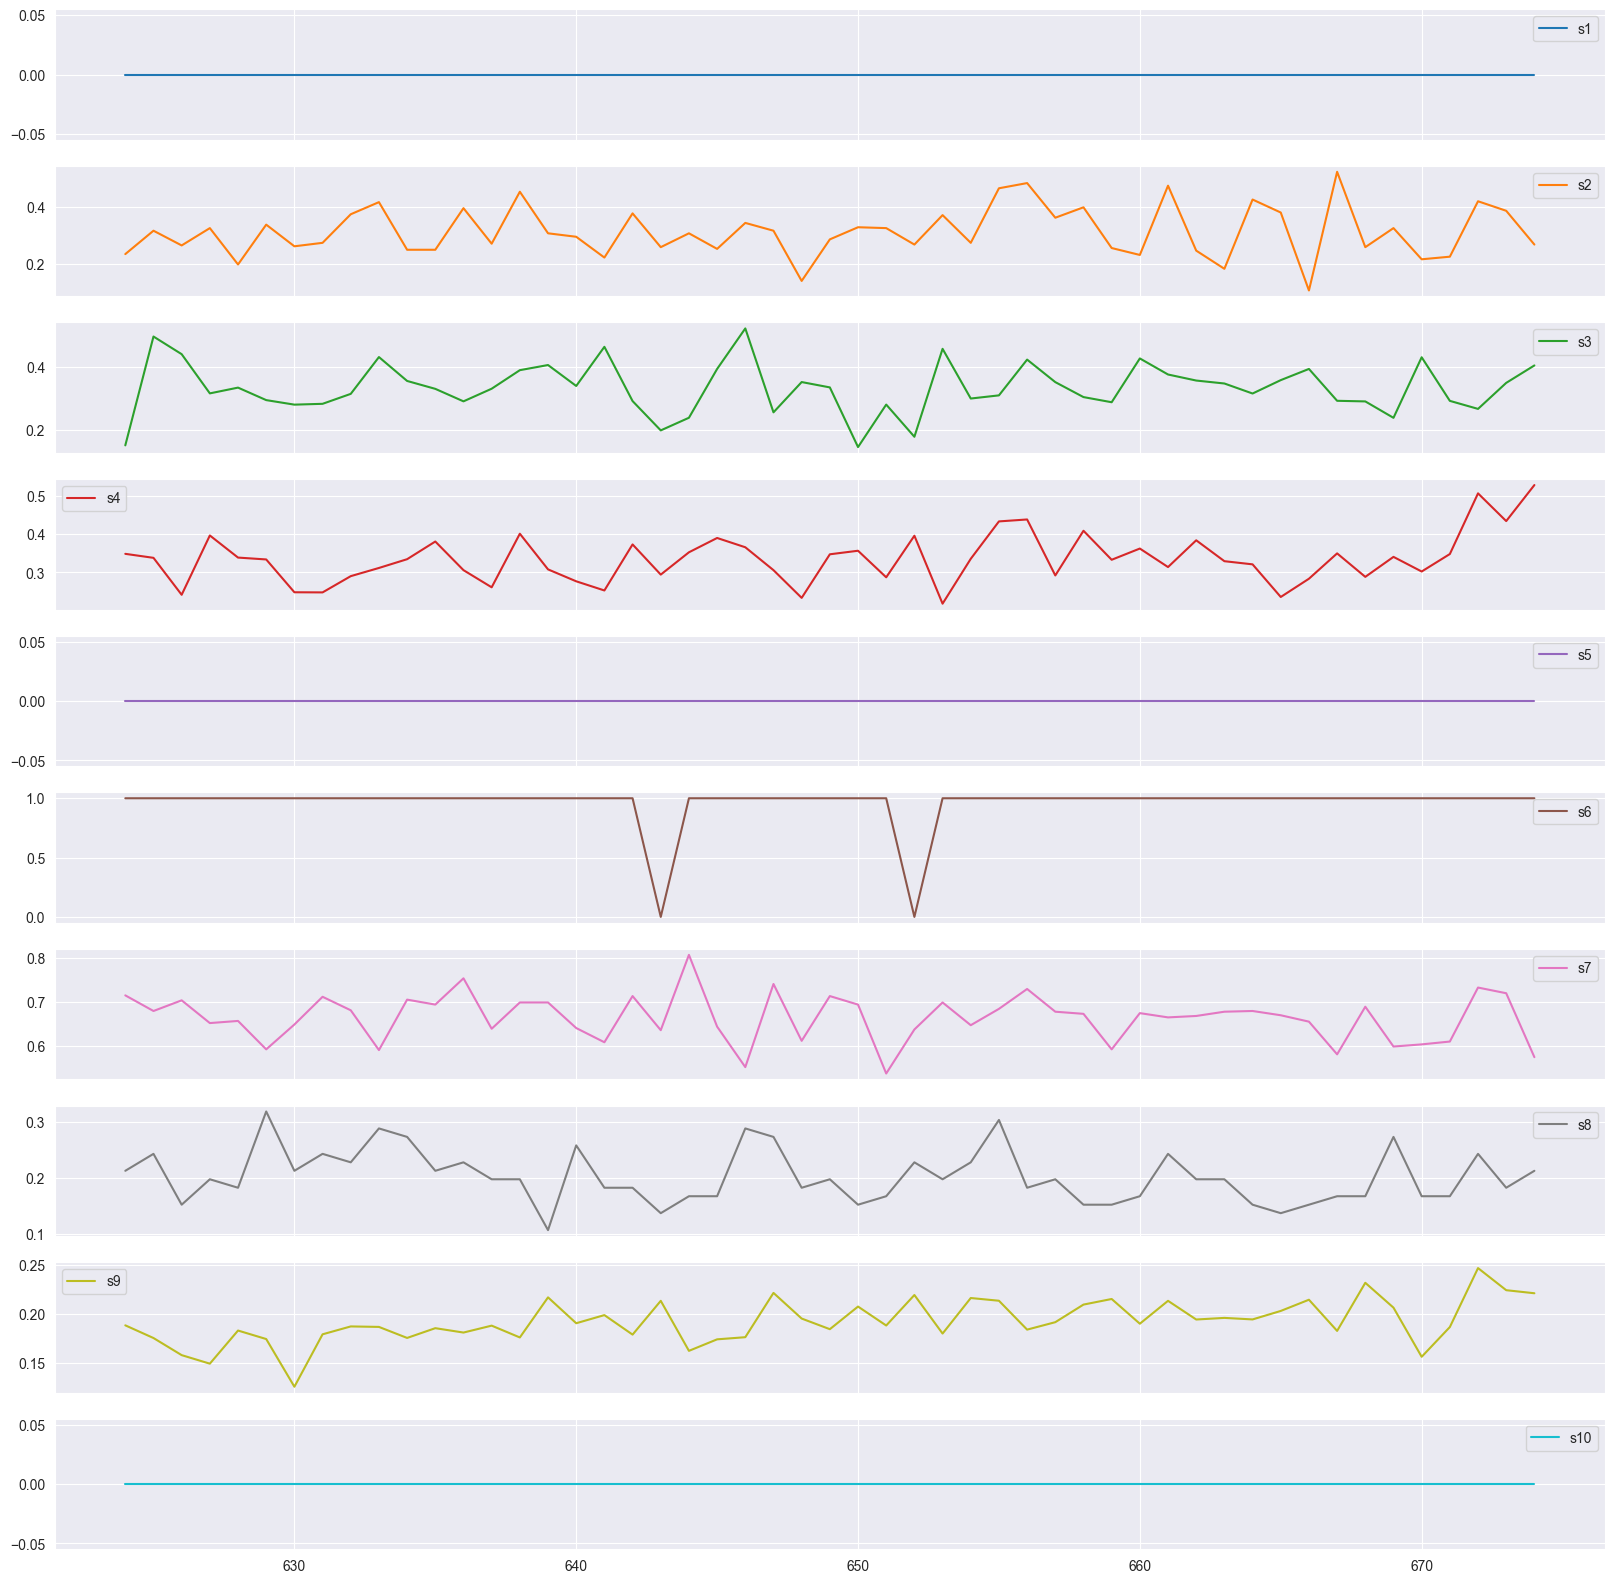

In [742]:
# вывод 1-10 параметров данных сенсоров для двигателя id == 7
ax1 = engine_id7_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

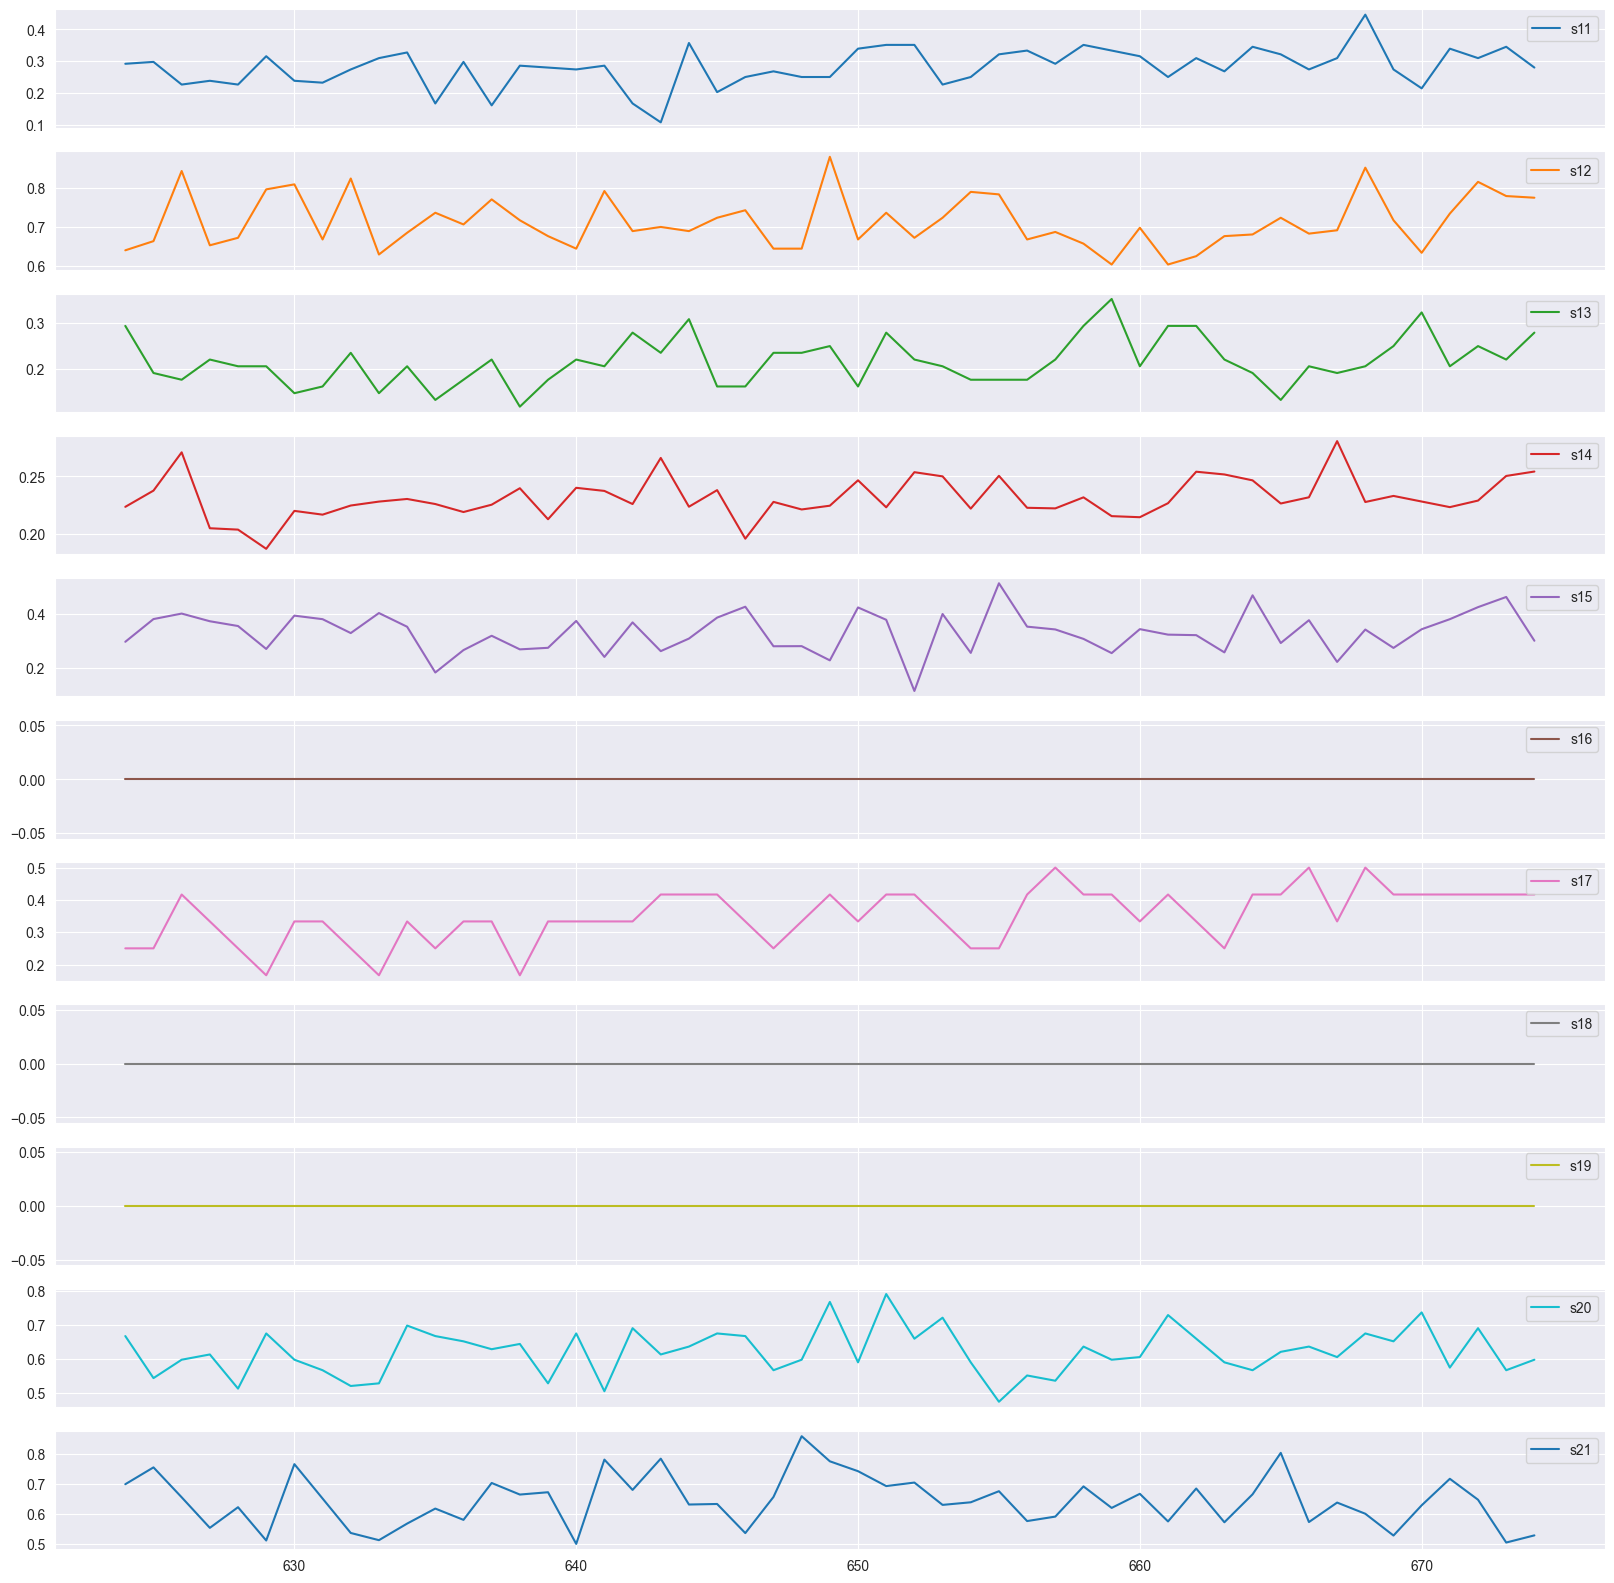

In [743]:
# вывод 11-21 параметров данных сенсоров для двигателя id == 7
ax2 = engine_id7_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

Слои Keras LSTM ожидают входных данных в виде массива numpy из 3 измерений (выборки, временные шаги, признаки), где выборки — это количество обучающих последовательностей, временные шаги — это окно или длина последовательности, а признаки — это количество признаков каждой последовательности на каждом временном шаге.

In [744]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Рассматриваются только последовательности, соответствующие длине окна, заполнение не используется. Это означает, что для тестирования
нам нужно отбросить те, которые меньше длины окна."""
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [745]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [746]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [747]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [748]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [749]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM Network

In [750]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

D:\Artem\Magistrature\1_sem\intellg_systems_and_techno\labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [751]:
print(model.summary())

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [752]:
print(seq_array)

[[[0.4597701  0.16666667 0.         ... 0.         0.7131783  0.7246617 ]
  [0.6091954  0.25       0.         ... 0.         0.6666667  0.73101354]
  [0.25287357 0.75       0.         ... 0.         0.627907   0.6213753 ]
  ...
  [0.6091954  0.5833333  0.         ... 0.         0.62015504 0.65009665]
  [0.41954023 0.9166667  0.         ... 0.         0.7131783  0.7671914 ]
  [0.31609195 0.41666666 0.         ... 0.         0.5503876  0.7130627 ]]

 [[0.6091954  0.25       0.         ... 0.         0.6666667  0.73101354]
  [0.25287357 0.75       0.         ... 0.         0.627907   0.6213753 ]
  [0.54022986 0.5        0.         ... 0.         0.5736434  0.66238606]
  ...
  [0.41954023 0.9166667  0.         ... 0.         0.7131783  0.7671914 ]
  [0.31609195 0.41666666 0.         ... 0.         0.5503876  0.7130627 ]
  [0.44252872 0.75       0.         ... 0.         0.62015504 0.65023476]]

 [[0.25287357 0.75       0.         ... 0.         0.627907   0.6213753 ]
  [0.54022986 0.5     

In [753]:
label_array = label_array.astype('int')
print(label_array)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [754]:
%%time
# fit the network
t1 = time()
# history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.1, verbose=1)
t2 = time()
print("Время выполнения: {:.2f}s".format(t2 - t1))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8068 - loss: 0.3903 - val_accuracy: 0.9584 - val_loss: 0.1104
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9625 - loss: 0.0968 - val_accuracy: 0.9642 - val_loss: 0.0739
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9674 - loss: 0.0789 - val_accuracy: 0.9655 - val_loss: 0.0657
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9699 - loss: 0.0753 - val_accuracy: 0.9840 - val_loss: 0.0518
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9688 - loss: 0.0698 - val_accuracy: 0.9840 - val_loss: 0.0504
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9723 - loss: 0.0660 - val_accuracy: 0.9559 - val_loss: 0.1074
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9712 - loss: 0.0699 - val_accuracy: 0.9891 - val_loss: 0.0344
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9753 - loss: 0.0550 - val_accuracy: 0.9802 - v

In [755]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9780 - loss: 0.0499
Accurracy: 0.9762651324272156


In [756]:
# make predictions and compute confusion matrix
# y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int")
y_true = label_array

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [757]:
y_true

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [758]:

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12361,   170],
       [  201,  2899]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12531
           1       0.94      0.94      0.94      3100

    accuracy                           0.98     15631
   macro avg       0.96      0.96      0.96     15631
weighted avg       0.98      0.98      0.98     15631



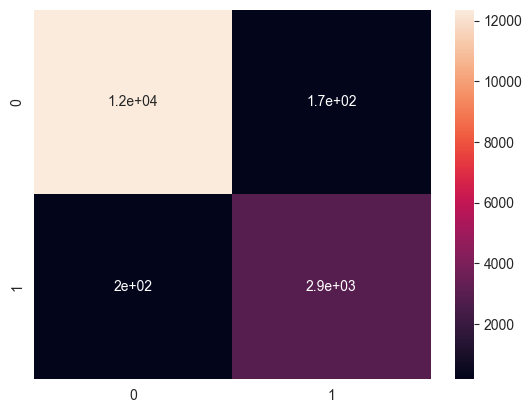

In [759]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)
_ = plt.show()

In [760]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9446073639622027 
 recall =  0.9351612903225807


In [761]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [762]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [763]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [764]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [765]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - 128ms/step - accuracy: 0.9570 - loss: 0.0874
Accurracy: 0.9569892287254333


In [766]:
# make predictions and compute confusion matrix
# y_pred_test = model.predict_classes(seq_array_test_last)
# y_pred_test = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int")
y_pred_test = model.predict(seq_array_test_last,verbose=1, batch_size=200)
for i, x in enumerate(y_pred_test):
    y_pred_test[i] = 1 if y_pred_test[i] > 0.5 else 0
y_pred_test.astype("int")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


In [767]:
print(y_true_test.shape)
print(y_pred_test.shape)

(93, 1)
(93, 1)


In [768]:
cm = confusion_matrix(y_true_test, y_pred_test)
cm

array([[67,  1],
       [ 3, 22]])

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        68
         1.0       0.96      0.88      0.92        25

    accuracy                           0.96        93
   macro avg       0.96      0.93      0.94        93
weighted avg       0.96      0.96      0.96        93



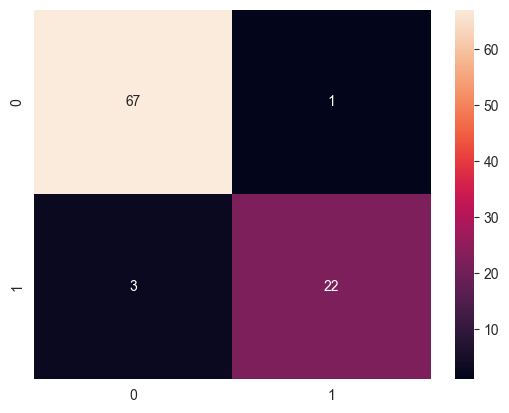

In [769]:
print(classification_report(y_true_test, y_pred_test))
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True)
_ = plt.show()

In [770]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9565217391304348 
 Recall:  0.88 
 F1-score: 0.9166666666666666


In [771]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN'])
results_df

,Accuracy,Precision,Recall,F1-score
RNN,0.956989,0.956522,0.88,0.916667


In [772]:
history.history['val_accuracy']

[0.9584398865699768,
 0.9641943573951721,
 0.9654731750488281,
 0.9840153455734253,
 0.9840153455734253,
 0.9558823704719543,
 0.989130437374115,
 0.9801790118217468,
 0.9680306911468506,
 0.9731457829475403]

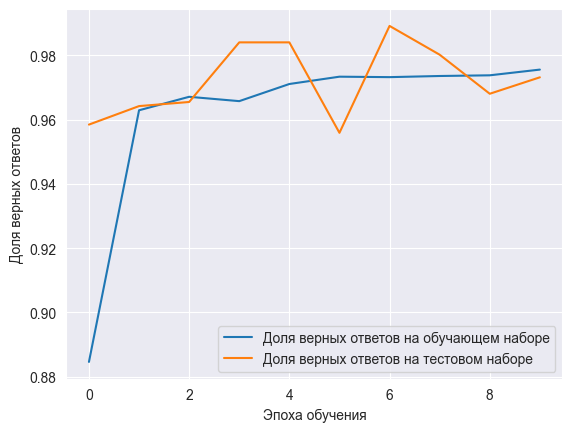

In [773]:
plt.close()
plt.plot(history.history['accuracy'], label="Доля верных ответов на обучающем наборе")
plt.plot(history.history['val_accuracy'], label="Доля верных ответов на тестовом наборе")
plt.xlabel("Эпоха обучения")
plt.ylabel("Доля верных ответов")
plt.legend()
plt.show()

# GRU Network

In [774]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

D:\Artem\Magistrature\1_sem\intellg_systems_and_techno\labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [775]:
print(model.summary)

<bound method Model.summary of <Sequential name=sequential_26, built=True>>


In [776]:
%%time
# fit the network
t1 = time()
# history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.1, verbose=1)
t2 = time()
print("Время выполнения: {:.2f}s".format(t2 - t1))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7992 - loss: 0.4241 - val_accuracy: 0.9239 - val_loss: 0.1799
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9371 - loss: 0.1502 - val_accuracy: 0.9437 - val_loss: 0.1171
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9576 - loss: 0.1007 - val_accuracy: 0.9680 - val_loss: 0.0653
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9703 - loss: 0.0660 - val_accuracy: 0.9751 - val_loss: 0.0572
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9762 - loss: 0.0558 - val_accuracy: 0.9763 - val_loss: 0.0570
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9765 - loss: 0.0570 - val_accuracy: 0.9636 - val_loss: 0.0819
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9775 - loss: 0.0516 - val_accuracy: 0.9763 - val_loss: 0.0546
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9719 - loss: 0.0646 - val_accuracy: 0.9840 - v

In [777]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9673 - loss: 0.0710
Accurracy: 0.9685880541801453


In [778]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int")
y_true = label_array

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [779]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12055,   476],
       [   15,  3085]])

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     12531
           1       0.87      1.00      0.93      3100

    accuracy                           0.97     15631
   macro avg       0.93      0.98      0.95     15631
weighted avg       0.97      0.97      0.97     15631



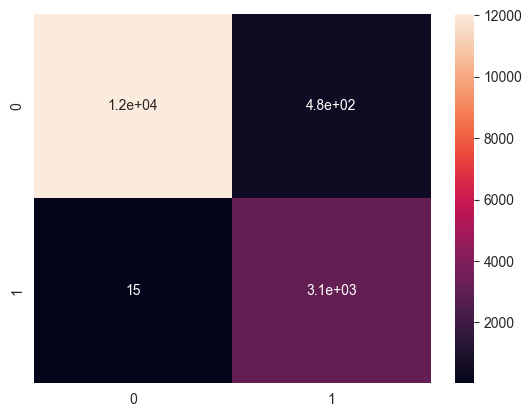

In [780]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)
_ = plt.show()

In [781]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.8663296826734064 
 recall =  0.9951612903225806


In [782]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - 82ms/step - accuracy: 0.9785 - loss: 0.0686
Accurracy: 0.9784946441650391


In [783]:
y_pred_test = model.predict(seq_array_test_last,verbose=1, batch_size=200)
for i, x in enumerate(y_pred_test):
    y_pred_test[i] = 1 if y_pred_test[i] > 0.5 else 0
y_pred_test.astype("int")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


In [784]:
cm = confusion_matrix(y_true_test, y_pred_test)
cm

array([[66,  2],
       [ 0, 25]])

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        68
         1.0       0.93      1.00      0.96        25

    accuracy                           0.98        93
   macro avg       0.96      0.99      0.97        93
weighted avg       0.98      0.98      0.98        93



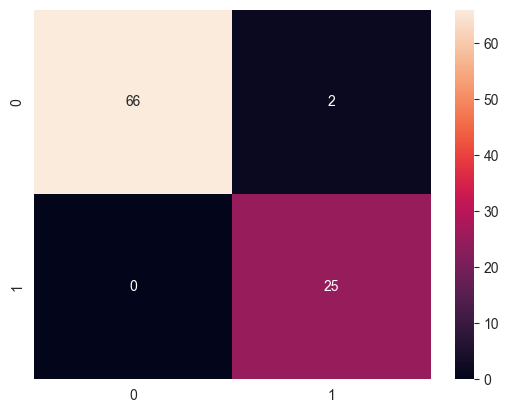

In [785]:
print(classification_report(y_true_test, y_pred_test))
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True)
_ = plt.show()

In [786]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9259259259259259 
 Recall:  1.0 
 F1-score: 0.9615384615384615


In [787]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU'])
results_df

,Accuracy,Precision,Recall,F1-score
GRU,0.978495,0.925926,1.0,0.961538


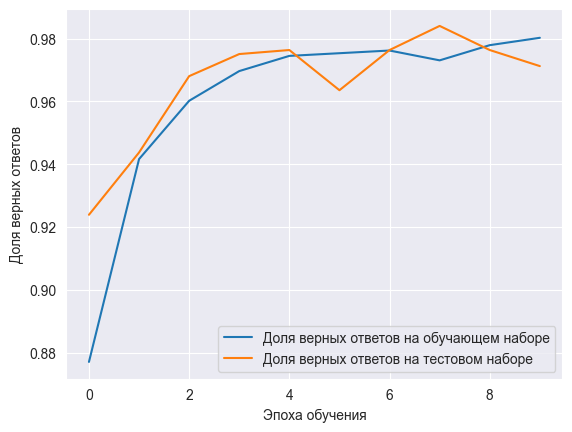

In [788]:
history.history['val_accuracy']
plt.close()
plt.plot(history.history['accuracy'], label="Доля верных ответов на обучающем наборе")
plt.plot(history.history['val_accuracy'], label="Доля верных ответов на тестовом наборе")
plt.xlabel("Эпоха обучения")
plt.ylabel("Доля верных ответов")
plt.legend()
plt.show()

In [789]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

D:\Artem\Magistrature\1_sem\intellg_systems_and_techno\labs\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [790]:
print(model.summary())

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 50, 100)        │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,201 (78.91 KB)

 Trainable params: 20,201 (78.91 KB)

 Non-trainable params: 0 (0.00 B)

None


In [791]:
seq_array.shape

(15631, 50, 25)

In [792]:
%%time
history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.1, verbose=1)
t1 = time()
t2 = time()
print("Время выполнения: {:.2f}s".format(t2 - t1))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8480 - loss: 0.3097 - val_accuracy: 0.9137 - val_loss: 0.1699
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9442 - loss: 0.1378 - val_accuracy: 0.9514 - val_loss: 0.1069
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9553 - loss: 0.1049 - val_accuracy: 0.9540 - val_loss: 0.1028
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9458 - loss: 0.1222 - val_accuracy: 0.9648 - val_loss: 0.0768
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9640 - loss: 0.0866 - val_accuracy: 0.9636 - val_loss: 0.0834
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9625 - loss: 0.0873 - val_accuracy: 0.9674 - val_loss: 0.0654
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9665 - loss: 0.0733 - val_accuracy: 0.9642 - val_loss: 0.0827
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9637 - loss: 0.0873 - val_accuracy: 0.9527 - v

In [793]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9817 - loss: 0.0463
Accurracy: 0.9797197580337524


In [794]:
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int")
y_true = label_array

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [795]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12404,   127],
       [  190,  2910]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12531
           1       0.96      0.94      0.95      3100

    accuracy                           0.98     15631
   macro avg       0.97      0.96      0.97     15631
weighted avg       0.98      0.98      0.98     15631



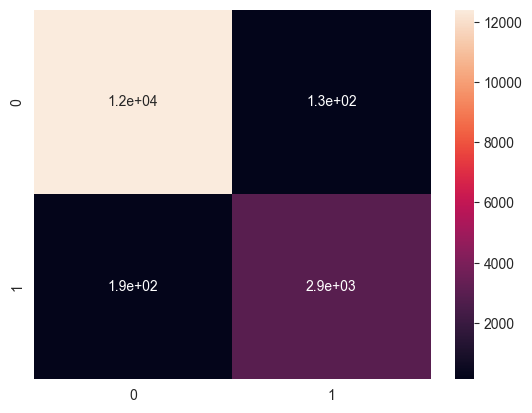

In [796]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)
_ = plt.show()

In [797]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9581824168587422 
 recall =  0.9387096774193548


In [798]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - 59ms/step - accuracy: 0.9677 - loss: 0.0590
Accurracy: 0.9677419066429138


In [799]:
y_pred_test = model.predict(seq_array_test_last,verbose=1, batch_size=200)
for i, x in enumerate(y_pred_test):
    y_pred_test[i] = 1 if y_pred_test[i] > 0.5 else 0
y_pred_test.astype("int")
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


In [800]:
cm = confusion_matrix(y_true_test, y_pred_test)
cm

array([[67,  1],
       [ 2, 23]])

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        68
         1.0       0.96      0.92      0.94        25

    accuracy                           0.97        93
   macro avg       0.96      0.95      0.96        93
weighted avg       0.97      0.97      0.97        93



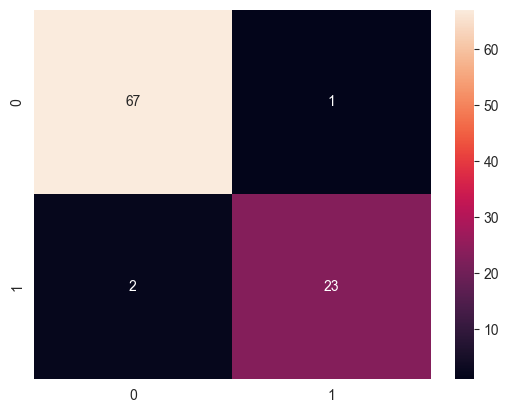

In [801]:
print(classification_report(y_true_test, y_pred_test))
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True)
_ = plt.show()

In [802]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score:', f1_test)

Precision:  0.9583333333333334 
 Recall:  0.92 
 F1-score: 0.9387755102040817


In [803]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.967742,0.958333,0.92,0.938776


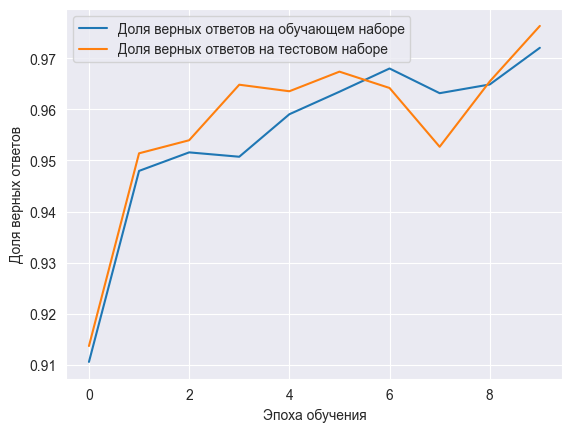

In [804]:
plt.close()
plt.plot(history.history['accuracy'], label="Доля верных ответов на обучающем наборе")
plt.plot(history.history['val_accuracy'], label="Доля верных ответов на тестовом наборе")
plt.xlabel("Эпоха обучения")
plt.ylabel("Доля верных ответов")
plt.legend()
plt.show()